# 0. 초기 세팅

In [1]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Pytorch에서 gpu를 사용하는 방법.
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
# print('Current cuda device ', torch.cuda.current_device())

In [2]:
import PIL

In [3]:
from matplotlib import pyplot as plt
import tifffile as tiff
from PIL import Image
import random

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.metrics import MeanIoU

In [5]:
from keras.utils import normalize
from keras.metrics import MeanIoU

In [6]:
from keras import backend as K

In [7]:
import tensorflow as tf
import segmentation_models as sm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


In [8]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [9]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [10]:
torch.cuda.memory_allocated() 

0

In [11]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.backends.cudnn.enabled)
print(torch.backends.cudnn.version())

True
8
True
8500


# 1. 데이터 준비

In [12]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

In [13]:
df_test = pd.read_csv('./test.csv')

In [ ]:
train_img_dir = './pro_data/data_for_training_and_testing/train/images/'
train_mask_dir = './pro_data/data_for_training_and_testing/train/masks/'

valid_img_dir = './pro_data/data_for_training_and_testing/val/images/'
valid_mask_dir = './pro_data/data_for_training_and_testing/val/masks/'

In [ ]:
data_train_img = sorted(os.listdir(train_img_dir))
data_train_mask = sorted(os.listdir(train_mask_dir))

data_val_img = sorted(os.listdir(valid_img_dir))
data_val_mask = sorted(os.listdir(valid_mask_dir))

In [ ]:
df_train = pd.DataFrame({'img_path': data_train_img, 'mask_path': data_train_mask})
df_valid = pd.DataFrame({'img_path': data_val_img, 'mask_path': data_val_mask})

In [ ]:
df_train

In [ ]:
SIZE_X = 224
SIZE_Y = 224
n_classes = 2

In [ ]:
train_images = []

for img_path in data_train_img:
    img = cv2.imread(train_img_dir + img_path, 1)
    train_images.append(img)

train_images = np.array(train_images)

In [ ]:
train_masks = []

for mask_path in data_train_mask :
    mask = cv2.imread(train_mask_dir + mask_path, 0)
    train_masks.append(mask)
    
train_masks = np.array(train_masks)

In [ ]:
valid_images = []

for img_path in data_val_img:
    img = cv2.imread(valid_img_dir + img_path, 1)
    valid_images.append(img)

valid_images = np.array(valid_images)

In [ ]:
valid_masks = []

for mask_path in data_val_mask :
    mask = cv2.imread(valid_mask_dir + mask_path, 0)
    valid_masks.append(mask)
    
valid_masks = np.array(valid_masks)

In [ ]:
X_train = train_images
y_train = train_masks
X_test = valid_images
y_test = valid_masks

# 1-1. 이미지 분석 

In [ ]:
from PIL import Image

In [ ]:
def show_hist(img):
    img_array = np.array(img)

    f = plt.figure(figsize=(18, 8))
    f.add_subplot(1, 2, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title('image', fontsize=20)
    f.add_subplot(1, 2, 2)
    plt.hist(img_array.flatten(), bins = 256, alpha=0.5)
    plt.title('histogram', fontsize=20)
    plt.xlabel('gray levels', fontsize = 15)
    plt.ylabel('pixel count', fontsize = 15)
    plt.show()

In [ ]:
tmp_img_path = train_img_dir + data_train_img[0]
tmp_img = valid_images[5]

In [ ]:
show_hist(tmp_img)

In [ ]:
show_hist(tmp_img)

transform = A.Compose([A.Normalize()])
tmp_img2 = transform(image=tmp_img)['image']
show_hist(tmp_img2)

In [ ]:
from PIL import ImageOps

def img_preprocess(img):
    img = Image.fromarray(np.uint8(img))
    img4eq = ImageOps.equalize(img)
    img4eq_array = np.array(img4eq)
    return (img, img4eq, img4eq_array)

In [ ]:
def show_hist2(tmp_img, img4eq, img4_array, img4eq_array):
    f=plt.figure(figsize=(14, 10))
    f.add_subplot(2, 2, 1)
    plt.imshow(tmp_img, cmap='gray')
    plt.title('original Image', fontsize=20)
    f.add_subplot(2, 2, 2)
    plt.imshow(img4eq, cmap='gray')
    plt.title('equalized Image', fontsize=20)
    f.add_subplot(2, 2, 3)
    plt.hist(img4_array.flatten(), bins = 256, alpha=0.5)
    plt.title('histogram', fontsize=20)
    plt.xlabel('gray levels', fontsize = 15)
    plt.ylabel('pixel count', fontsize = 15)
    f.add_subplot(2, 2, 4)
    plt.hist(img4eq_array.flatten(), bins = 256, alpha=0.5)
    plt.title('histogram', fontsize=20)
    plt.xlabel('gray levels', fontsize = 15)
    plt.ylabel('pixel count', fontsize = 15)
    plt.show()

In [ ]:
result_contrast = img_preprocess(tmp_img)

In [ ]:
show_hist2(tmp_img, result_contrast[1], tmp_img, result_contrast[2])

In [ ]:
import PIL, PIL.ImageOps

In [ ]:
img = Image.fromarray(np.uint8(tmp_img))
result_img = PIL.ImageOps.autocontrast(img, cutoff=1)

In [ ]:
show_hist(result_img)

In [ ]:
denoised_img = cv2.fastNlMeansDenoisingColored(np.array(result_img), None, 5, 5, 5, 5)

In [ ]:
show_hist(denoised_img)

In [ ]:
img2 = Image.fromarray(np.uint8(denoised_img))
Sharpness_image = PIL.ImageEnhance.Sharpness(img2).enhance(1.2)

In [ ]:
show_hist(Sharpness_image)

In [ ]:
type(Sharpness_image)

In [ ]:
def img_preprocess(img):
    img = Image.fromarray(np.uint8(img))
    result_img = PIL.ImageOps.autocontrast(img, cutoff=1)
    denoised_img = cv2.fastNlMeansDenoisingColored(np.array(result_img), None, 5, 5, 5, 5)
    img2 = Image.fromarray(np.uint8(denoised_img))
    Sharpness_image = PIL.ImageEnhance.Sharpness(img2).enhance(1.2)  
    return np.array(Sharpness_image)

### Custom Dataset & DataLoader

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, dataset, lst_path, transform=None, infer=False):
        self.data = dataset
        self.transform = transform
        self.infer = infer
        self.lst_path = lst_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.lst_path[0] + self.data.iloc[idx, 0]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = img_preprocess(image)
                image = self.transform(image=image)['image']
            return image

        mask_path = self.lst_path[1] + self.data.iloc[idx, 1]
        mask = cv2.imread(mask_path, 0)

        if self.transform:
            image = img_preprocess(image)
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
transform = A.Compose([
    A.Normalize(),        # 기존
    ToTensorV2()          # 기존
])

In [ ]:
trainset = SatelliteDataset(dataset = df_train, transform=transform, lst_path = [train_img_dir, train_mask_dir])
validset = SatelliteDataset(dataset = df_valid, transform=transform, lst_path = [valid_img_dir, valid_mask_dir])

In [ ]:
train_dataloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=48)
valid_dataloader = DataLoader(validset, batch_size=16, shuffle=False, num_workers=48)

In [ ]:
valid_dataloader_2 = DataLoader(validset, batch_size=32, shuffle=False, num_workers=48)

# 2. 모델 정의

In [ ]:
import torchvision.models as models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [ ]:
import torch
import torch.nn as nn
import torchvision
resnet = torchvision.models.resnet.resnet50(pretrained=True)


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=1):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

In [ ]:
#model = ResNetUNet(1)
model = UNetWithResnet50Encoder()
model = nn.DataParallel(model,device_ids = [4, 5, 6, 7])
model.to(device)

In [ ]:
model = torch.load("./ex_model1_res.pth", map_location=device)

# 2-2. 모델 학습

## 3-1) optimizer 정의

In [ ]:
decay = []
no_decay = []
bn_wd_skip = True

for name, param in model.named_parameters():
    if ("bn" in name) and bn_wd_skip:
        no_decay.append(param)
    else:
        decay.append(param)
        
per_param_args = [{"params": decay}, {"params": no_decay, "weight_decay": 0.0}]

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## 3-2) loss function 정의

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()

## 3-3) lr- scheduler

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F

import math
import time

In [ ]:
def get_cosine_schedule_with_warmup(
    optimizer,
    num_training_steps,
    num_cycles=7.0 / 16.0,
    num_warmup_steps=0,
    last_epoch=-1,
):
    """
    Get cosine scheduler (LambdaLR).
    if warmup is needed, set num_warmup_steps (int) > 0.
    """

    def _lr_lambda(current_step):
        """
        _lr_lambda returns a multiplicative factor given an interger parameter epochs.
        Decaying criteria: last_epoch
        """

        if current_step < num_warmup_steps:
            _lr = float(current_step) / float(max(1, num_warmup_steps))
        else:
            num_cos_steps = float(current_step - num_warmup_steps)
            num_cos_steps = num_cos_steps / float(
                max(1, num_training_steps - num_warmup_steps)
            )
            _lr = max(0.0, math.cos(math.pi * num_cycles * num_cos_steps))
        return _lr

    return LambdaLR(optimizer, _lr_lambda, last_epoch)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(
    optimizer, 10000, num_warmup_steps=2 ** 20 * 0
)

In [ ]:
# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트 만든다.
# list_epoch = []
# list_train_loss = []
# list_val_loss = []

# training loop
for epoch in range(2):  # 10 에폭 동안 학습합니다.
    # ===================== Train ===================== #
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    scheduler.step()
    result = f'(train) Epoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}'
#     list_epoch.append(epoch)
#     list_train_loss.append(epoch_loss/len(train_dataloader))
    
#     # ===================== Validation ===================== #
#     model.eval()
#     epoch_loss = 0
#     for images, masks in tqdm(valid_dataloader):
#         images = images.float().to(device)
#         masks = masks.float().to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, masks.unsqueeze(1))

#         epoch_loss += loss.item()

#     list_val_loss.append(epoch_loss/len(valid_dataloader))
    
    print(result)    
#     print(f'(valid) Epoch {epoch+1}, Loss: {epoch_loss/len(valid_dataloader)}')

In [ ]:
torch.save(model, './ex_model1_res.pth')

# 3. Valid set 에 대한 결과 예측

In [ ]:
with torch.no_grad():
    model1.eval()
    model2.eval()
    model3.eval()
    
    result_model1 = []
    result_model2 = []
    result_model3 = []
    
    for images, mask in tqdm(valid_dataloader):
#         images_ = images.float()
        images = images.float().to(device)

        outputs1 = model1(images)
#         outputs2 = model2(images_)
        outputs3 = model3(images)
        
        masks1 = torch.sigmoid(outputs1).cpu().numpy()
#         masks2 = torch.sigmoid(outputs2['masks']).cpu().numpy()
        masks3 = torch.sigmoid(outputs3).cpu().numpy()
        
        masks1 = np.squeeze(masks1, axis=1)
#         masks2 = np.squeeze(masks2, axis=1)
        masks3 = np.squeeze(masks3, axis=1)
        
        masks1 = (masks1 > 0.4).astype(np.uint8) # Threshold = 0.35
#         masks2 = (masks2 > 0.4).astype(np.uint8) # Threshold = 0.35
        masks3 = (masks3 > 0.4).astype(np.uint8) # Threshold = 0.35

        result_model1.append(masks1)
#         result_model2.append(masks2)
        result_model3.append(masks3)

In [ ]:
with torch.no_grad():
    model.eval()
    
    result_model4 = []
    
    for images, mask in tqdm(valid_dataloader):
        images = images.float().to(device)

        outputs4 = model(images)
        masks4 = torch.sigmoid(outputs4).cpu().numpy()
        masks4 = np.squeeze(masks4, axis=1)
        masks4 = (masks4 > 0.4).astype(np.uint8) # Threshold = 0.35

        result_model4.append(masks4)

In [ ]:
np.save('result_model1', np.array(result_model1))
np.save('result_model3', np.array(result_model3))

In [ ]:
np.save('result_model2', np.array(result_model2))

In [ ]:
np.save('result_model4', np.array(result_model4))

In [ ]:
result_model1 = np.load('result_model1.npy', allow_pickle=True)
result_model3 = np.load('result_model3.npy', allow_pickle=True)

In [ ]:
result_model2 = np.load('result_model2.npy', allow_pickle=True)

In [ ]:
result_model4 = np.load('result_model4.npy', allow_pickle=True)

In [ ]:
model2.eval()
result_model2 = []
idx = 0

for images, masks in tqdm(valid_dataloader_2):
    for j in range(32):
        images = images.float()
        with torch.no_grad():
            result = model2(images)[0]
        all_preds_masks = np.zeros((224, 224))
        chk = -1
        if (len(result['scores']) == 0):
            rle = all_preds_masks
            result_model2.append(rle)
            continue
        if (max(result['scores']) < 0.4):
            chk = max(result['scores'])
        for i, mask in enumerate(result['masks']):
            score = result['scores'][i].cpu().item()

            # 가장 연관성 높은 mask만 남기기
            mask = mask.cpu().numpy()
            if(score <= 0.4):
                if (chk != score):
                    continue
            all_preds_masks = np.logical_or(all_preds_masks, mask > 0.5)
            rle = all_preds_masks
        result_model2.append(rle)
        print(f"{idx}:complete {j}")
    idx += 1

# 4. 앙상블 가중치 구하기

In [ ]:
pred1 = result_model1
# pred2 = result_model2
pred3 = result_model3

In [ ]:
pred4 = result_model4

In [ ]:
tmp_pred1 = np.concatenate(pred1, axis=0)
# tmp_pred2 = np.concatenate(pred2, axis=0)
tmp_pred3 = np.concatenate(pred3, axis=0)

In [ ]:
tmp_pred4 = np.concatenate(pred4, axis=0)

In [ ]:
tmp_pred4.shape

In [ ]:
preds = np.array([tmp_pred1, tmp_pred4, tmp_pred3])
# preds = np.array([tmp_pred1, tmp_pred3])

In [ ]:
preds.shape

In [ ]:
weights = [0.6, 0.2, 0.2]

In [ ]:
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))

In [ ]:
weighted_preds.shape

In [ ]:
with tf.device('/cpu:0'):
    n_classes = 2
    IOU1 = MeanIoU(num_classes=n_classes)
    IOU4 = MeanIoU(num_classes=n_classes)
    IOU3 = MeanIoU(num_classes=n_classes)
    IOU_weighted = MeanIoU(num_classes=n_classes)

    IOU1.update_state(valid_masks, tmp_pred1)
    IOU4.update_state(valid_masks, tmp_pred4)
    IOU3.update_state(valid_masks, tmp_pred3)
    IOU_weighted.update_state(valid_masks, weighted_preds)

    print('IOU Score for model1 = ', IOU1.result().numpy())
    print('IOU Score for model2 = ', IOU4.result().numpy())
    print('IOU Score for model3 = ', IOU3.result().numpy())
    print('IOU Score for weighted average ensemble = ', IOU_weighted.result().numpy())

In [ ]:
num_classes = 2

values1 = np.array(IOU1.get_weights()).reshape(num_classes, num_classes)
values3 = np.array(IOU3.get_weights()).reshape(num_classes, num_classes)

In [ ]:
values3

In [ ]:
with tf.device('/cpu:0'):
    df = pd.DataFrame([])

    for w1 in range(6, 0, -1):
        w2 = 0
        w3 = 10 - (w1 + w2)
        wts = [w1/10.,w2/10.,w3/10.]

        IOU_wted = MeanIoU(num_classes=n_classes) 
        wted_ensemble_pred = np.tensordot(preds, wts, axes=((0),(0)))
        IOU_wted.update_state(valid_masks, wted_ensemble_pred)
        print("Now predciting for weights :", w1/10., w2/10., w3/10., " : IOU = ", IOU_wted.result().numpy())
        df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                     'wt3':wts[2], 'IOU': IOU_wted.result().numpy()}, index=[0]), ignore_index=True)

    max_iou_row = df.iloc[df['IOU'].idxmax()]
    print("Max IOU of ", max_iou_row[3], " obained with w1=", max_iou_row[0],
          " w2=", max_iou_row[1], " and w3=", max_iou_row[2])      

# 5. 성능 평가

**성능 평가를 위해 valid set에 대해서 결과 확인**

**[해야될 것] 1)~3) 까지 결과 공유**

### 1) true_mask vs pred_mask 이미지 비교

In [ ]:
import numpy as np
import pandas as pd
from typing import List, Union
from joblib import Parallel, delayed

In [ ]:
import matplotlib.pyplot as plt

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            img = cv2.imread(display_list[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.uint8).copy()
        if i == 1:
            img = cv2.imread(display_list[i], 0)
        if i == 2:
#             img = rle_decode(display_list[i], shape = (224, 224)) # shape 설정
            img = display_list[i]

        plt.imshow(img)
        plt.axis('off')
    plt.show()

idx = 1000

valid_img_path_idx = valid_img_dir + df_valid['img_path'][idx]
valid_mask_path_idx = valid_mask_dir + df_valid['mask_path'][idx]
valid_pred_mask_idx = tmp_pred4[idx]

display_list = [valid_img_path_idx, valid_mask_path_idx, valid_pred_mask_idx]
display(display_list)

In [ ]:
weighted_preds_test = np.where(weighted_preds > 0.5, 1, 0)

In [ ]:
idx = 5

valid_img_path_idx = valid_img_dir + df_valid['img_path'][idx]
valid_mask_path_idx = valid_mask_dir + df_valid['mask_path'][idx]

In [ ]:
display_list = [valid_img_path_idx, valid_mask_path_idx, tmp_pred4[idx]]
display(display_list)

### 2) Dice Score

In [ ]:
def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)


def calculate_dice_scores(pred_mask, gt_mask, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''

    def calculate_dice(pred_mask, gt_mask):
        pred_mask = pred_mask
        gt_mask = gt_mask


        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None


    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred, gt) for pred, gt in zip(pred_mask, gt_mask)
    )


    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)

In [ ]:
calculate_dice_scores(tmp_pred4, valid_masks, img_shape=(224, 224))

### 3) Class 별 IOU

In [ ]:
valid_masks.shape

In [ ]:
import numpy as np

def calculate_iou(outputs, labels, num_classes):
    iou_per_class = np.zeros(num_classes)
    
    for class_idx in range(num_classes):
        # 클래스별 True Positive, False Positive, False Negative 계산
        true_positive = np.sum(np.logical_and(outputs == class_idx, labels == class_idx))
        false_positive = np.sum(np.logical_and(outputs == class_idx, labels != class_idx))
        false_negative = np.sum(np.logical_and(outputs != class_idx, labels == class_idx))
        
        # 클래스별 IoU 계산
        iou = true_positive / (true_positive + false_positive + false_negative + 1e-10)
        iou_per_class[class_idx] = iou
        
    return iou_per_class

# 예시 사용
outputs = tmp_pred4
labels = valid_masks
num_classes = 2
iou_per_class = calculate_iou(outputs, labels, num_classes)

print("클래스별 IoU:", iou_per_class)

In [ ]:
totaliou = iou_per_class

In [ ]:
def printClassScores(totaliou):
    label = ['background', 'building']
    print('classes          IoU      nIoU')
    print('--------------------------------')
    for i, iou in enumerate(totaliou):
        labelName = label[i]
        iouStr = f'{iou:>5.3f}'
        niouStr = 'empty'
        print('{:<14}: '.format(labelName) + iouStr + '    ' + niouStr)
    print('--------------------------------')
    print(f'Score Average : {(np.sum(totaliou) / 2):>5.3f}' + '    ' + niouStr)

In [ ]:
printClassScores(totaliou)

# 4. 예측

In [ ]:
class SatelliteDatasetForTest(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = 'data/' + self.data.iloc[idx, 1][1:]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = img_preprocess(image)
                image = self.transform(image=image)['image']
            return image

        mask_rle = 'data/' + self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            image = img_preprocess(image)
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
test_transform = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

In [ ]:
test_dataset = SatelliteDatasetForTest(csv_file='./test.csv', transform=test_transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=48)

In [ ]:
with torch.no_grad():
    model1.eval()
    model3.eval()
    
    result_test1 = []
    result_test3 = []
    
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs1 = model1(images)
        outputs3 = model3(images)
        
        masks1 = torch.sigmoid(outputs1).cpu().numpy()
        masks3 = torch.sigmoid(outputs3).cpu().numpy()
        
        masks1 = np.squeeze(masks1, axis=1)
        masks3 = np.squeeze(masks3, axis=1)
        
        masks1 = (masks1 > 0.4).astype(np.uint8) # Threshold = 0.35
        masks3 = (masks3 > 0.4).astype(np.uint8) # Threshold = 0.35

        result_test1.append(masks1)
        result_test3.append(masks3)

In [ ]:
with torch.no_grad():
    model.eval()
    
    result_test4 = []
    
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        
        outputs4 = model(images)
        
        masks4 = torch.sigmoid(outputs4).cpu().numpy()
        
        masks4 = np.squeeze(masks4, axis=1)
        
        masks4 = (masks4 > 0.4).astype(np.uint8) # Threshold = 0.35

        result_test4.append(masks4)

In [ ]:
tmp_result_test1 = np.array(result_test1)
tmp_result_test3 = np.array(result_test3)

In [ ]:
np.save('result_test4', np.array(result_test4))

In [ ]:
result_test4 = np.load('result_test4.npy', allow_pickle=True)

In [ ]:
tmp_result_test4 = np.array(result_test4)

In [ ]:
tmp_result_test1 = pd.read_csv('submit(resnetunet-agu-re-7-64).csv')

In [ ]:
rle_decode(tmp_result_test1['mask_rle'][0], shape = (224, 224))

In [ ]:
tmp_result_test4.shape

In [ ]:
tmp_pred_result1 = np.concatenate(tmp_result_test1, axis=0)
tmp_pred_result3 = np.concatenate(tmp_result_test3, axis=0)

In [ ]:
tmp_pred_result4 = np.concatenate(tmp_result_test4, axis=0)

In [ ]:
df_test

In [ ]:
df_test['img_path'][idx]

In [16]:
def display(lst_display):
    plt.figure(figsize=(15, 15))
    if len(lst_display) == 2:
        title = ['Input Image', 'Predicted Mask']
    else:
        title = ['Input Image', 'Predicted Mask', 'Predicted Mask2']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            img = cv2.imread(display_list[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.uint8).copy()
        if i == 1 or i == 2:
            img = display_list[i]

        plt.imshow(img)
        plt.axis('off')
    plt.show()

idx = 22015

test_img_path_idx = 'data' + df_test['img_path'][idx][1:]
test_pred_mask_idx = tmp_pred_result4[idx]
test_pred_mask2_dix = rle_decode(tmp_result_test1['mask_rle'][idx], shape = (224, 224))

display_list = [test_img_path_idx, test_pred_mask_idx, test_pred_mask2_dix]
display(display_list)

NameError: name 'tmp_pred_result4' is not defined

In [ ]:
tmp_pred_result1 = [rle_decode(tmp_result_test1['mask_rle'][i], shape = (224, 224)) for i in range(len(tmp_result_test1['mask_rle']))]

In [ ]:
tmp_pred1.shape

In [ ]:
len(tmp_pred_result1)

In [ ]:
test_preds_ls = np.array([tmp_pred_result1, tmp_pred_result4])
# preds = np.array([tmp_pred1, tmp_pred3])

In [ ]:
np.save('test_preds_ls', test_preds_ls)

In [ ]:
test_preds.shape

In [ ]:
test_weights = [0.65, 0.35]

In [ ]:
weighted_preds = np.tensordot(test_preds_ls, test_weights, axes=((0),(0)))

In [ ]:
result_test4

In [ ]:
weighted_preds_yes = np.where(weighted_preds > 0.4, 1, 0)

In [ ]:
idx = 22015

test_img_path_idx = 'data' + df_test['img_path'][idx][1:]
test_pred_mask_idx = weighted_preds[idx]

display_list = [test_img_path_idx, weighted_preds]
display(display_list)

In [ ]:
tmp_pred1_slice1 = tmp_pred_result1[:int(len(tmp_pred_result1)/4)]
tmp_pred3_slice1 = tmp_pred_result4[:int(len(tmp_pred_result1)/4)]

test_preds_slice1 = np.array([tmp_pred1_slice1, tmp_pred3_slice1])

In [ ]:
tmp_pred1_slice2 = tmp_pred_result1[int(len(tmp_pred_result1)/4):int(len(tmp_pred_result1)/2)]
tmp_pred3_slice2 = tmp_pred_result4[int(len(tmp_pred_result1)/4):int(len(tmp_pred_result1)/2)]

test_preds_slice2 = np.array([tmp_pred1_slice2, tmp_pred3_slice2])

In [ ]:
tmp_pred1_slice3 = tmp_pred_result1[int(len(tmp_pred_result1)/2):int(3 * len(tmp_pred_result1)/4)]
tmp_pred3_slice3 = tmp_pred_result4[int(len(tmp_pred_result1)/2):int(3 * len(tmp_pred_result1)/4)]

test_preds_slice3 = np.array([tmp_pred1_slice3, tmp_pred3_slice3])

In [ ]:
tmp_pred1_slice4 = tmp_pred_result1[int(3 * len(tmp_pred_result1)/4):]
tmp_pred3_slice4 = tmp_pred_result4[int(3 * len(tmp_pred_result1)/4):]

test_preds_slice4 = np.array([tmp_pred1_slice4, tmp_pred3_slice4])

In [ ]:
weighted_preds_slice1 = np.tensordot(test_preds_slice1, test_weights, axes=((0),(0)))

In [ ]:
weighted_preds_slice2 = np.tensordot(test_preds_slice2, test_weights, axes=((0),(0)))
weighted_preds_slice3 = np.tensordot(test_preds_slice3, test_weights, axes=((0),(0)))
weighted_preds_slice4 = np.tensordot(test_preds_slice4, test_weights, axes=((0),(0)))

In [ ]:
weighted_preds = [weighted_preds_slice1, weighted_preds_slice2, weighted_preds_slice3, weighted_preds_slice4]

In [ ]:
weighted_preds = np.concatenate(weighted_preds, axis=0)

In [ ]:
np.save('weighted_preds', weighted_preds)

In [14]:
weighted_preds = np.load('weighted_preds.npy', allow_pickle=True)

In [15]:
weighted_preds_yes = np.where(weighted_preds > 0.4, 1, 0)

In [ ]:
weighted_preds.shape

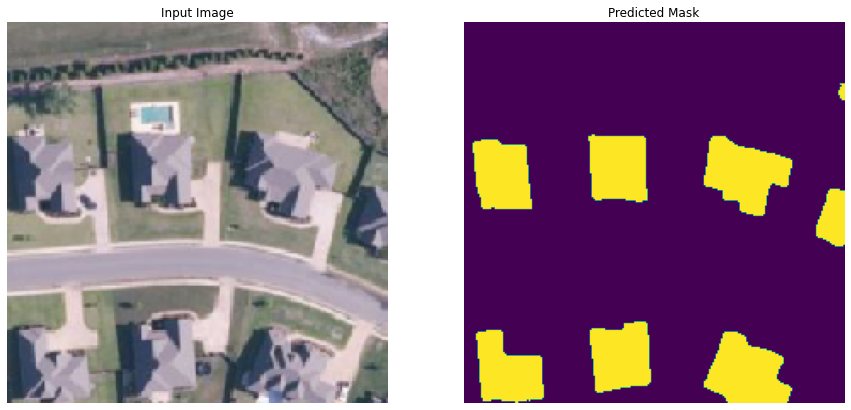

In [21]:
idx = 5

test_img_path_idx = 'data' + df_test['img_path'][idx][1:]
test_pred_mask_idx = weighted_preds_yes[idx]

display_list = [test_img_path_idx, test_pred_mask_idx]
display(display_list)

In [ ]:
weighted_preds_yes[0]

In [ ]:
len(tmp_pred4)

In [22]:
result = []

for i in range(len(weighted_preds_yes)):
    mask_rle = rle_encode(weighted_preds_yes[i])
    if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
        result.append(-1)
    else:
        result.append(mask_rle)

In [23]:
len(result)

60640

# 제출 코드

In [24]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [25]:
submit.to_csv('./contrast_en2.csv', index=False)